In [11]:
#!/usr/bin/env python
# coding: utf-8

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import timm
from sklearn.model_selection import train_test_split

# Load data
df_mass_test = pd.read_csv(r'csv/mass_case_description_test_set.csv')
df_mass_train = pd.read_csv(r'csv/mass_case_description_train_set.csv')

df_mass = pd.concat([df_mass_train, df_mass_test])
df_mass['image file path'] = df_mass['image file path'].str.replace('.dcm', '.jpg')

# Function to keep the last two parts of the file path
def keep_last_two_parts(path):
    parts = path.split('/')
    return '/' + '/'.join(parts[-2:])

df_mass['image file path'] = df_mass['image file path'].apply(keep_last_two_parts)

base_dir = "C:/Users/shash/OneDrive/Documents/Master's/DSCI Capstone Project/archive/jpeg"

def prepend_base_dir(file_path):
    return os.path.join(base_dir, file_path.lstrip('/'))

df_mass['image file path'] = df_mass['image file path'].apply(prepend_base_dir)

import os

def find_correct_filename(directory):
    print(f"Looking in directory: {directory}")
    
    try:
        # List all files in the directory
        files = os.listdir(directory)
        print(f"Files in directory: {files}")
        
        # If there are files, return the first one (or apply another selection logic)
        if files:
            correct_file = files[0]  # You could modify this logic to better suit your needs
            print(f"Selected file: {correct_file}")
            return correct_file
        
        print("No files found in directory")
    except FileNotFoundError as e:
        print(f"Directory not found: {directory}")
    except Exception as e:
        print(f"An error occurred: {e}")
        
    return None

def correct_image_paths(df, base_dir):
    corrected_paths = []
    
    for index, row in df.iterrows():
        study_path = row['image file path']
        study_dir = os.path.join(base_dir, '/'.join(study_path.split('/')[:-1]))
        
        print(f"Processing row {index}: {study_path}")
        
        # Get the correct filename (ignore the one in the DataFrame)
        correct_filename = find_correct_filename(study_dir)
        
        if correct_filename:
            corrected_path = os.path.join(study_dir, correct_filename)
            corrected_paths.append(corrected_path)
        else:
            corrected_paths.append(None)  # Handle missing files
    
    return corrected_paths

# Apply the function to your DataFrame
df_mass['corrected image file path'] = correct_image_paths(df_mass, base_dir)

Processing row 0: C:/Users/shash/OneDrive/Documents/Master's/DSCI Capstone Project/archive/jpeg\1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/000000.jpg
Looking in directory: C:/Users/shash/OneDrive/Documents/Master's/DSCI Capstone Project/archive/jpeg\1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515
Files in directory: ['1-211.jpg']
Selected file: 1-211.jpg
Processing row 1: C:/Users/shash/OneDrive/Documents/Master's/DSCI Capstone Project/archive/jpeg\1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.jpg
Looking in directory: C:/Users/shash/OneDrive/Documents/Master's/DSCI Capstone Project/archive/jpeg\1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834
Files in directory: ['1-207.jpg']
Selected file: 1-207.jpg
Processing row 2: C:/Users/shash/OneDrive/Documents/Master's/DSCI Capstone Project/archive/jpeg\1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/000000.jpg
Looking in directory: C:/Users/shash/

In [13]:
# Filter views
def filter_views(df, view_list=['CC', 'MLO']):
    return df[df['image view'].isin(view_list)]

df_mass_filtered = filter_views(df_mass, ['CC'])
df_mass_filtered = df_mass_filtered.dropna(subset=['corrected image file path'])

Starting epoch 1/10
Processing batch 1
Shape after forward_features: torch.Size([32, 7, 7, 768])
Shape after global average pooling: torch.Size([32, 768])
Shape after linear layer: torch.Size([32, 1])
Batch 1, Loss: 0.7325
Processing batch 2
Shape after forward_features: torch.Size([32, 7, 7, 768])
Shape after global average pooling: torch.Size([32, 768])
Shape after linear layer: torch.Size([32, 1])
Batch 2, Loss: 0.6384
Processing batch 3
Shape after forward_features: torch.Size([32, 7, 7, 768])
Shape after global average pooling: torch.Size([32, 768])
Shape after linear layer: torch.Size([32, 1])
Batch 3, Loss: 0.7614
Processing batch 4
Shape after forward_features: torch.Size([32, 7, 7, 768])
Shape after global average pooling: torch.Size([32, 768])
Shape after linear layer: torch.Size([32, 1])
Batch 4, Loss: 0.6234
Processing batch 5
Shape after forward_features: torch.Size([32, 7, 7, 768])
Shape after global average pooling: torch.Size([32, 768])
Shape after linear layer: torch.S

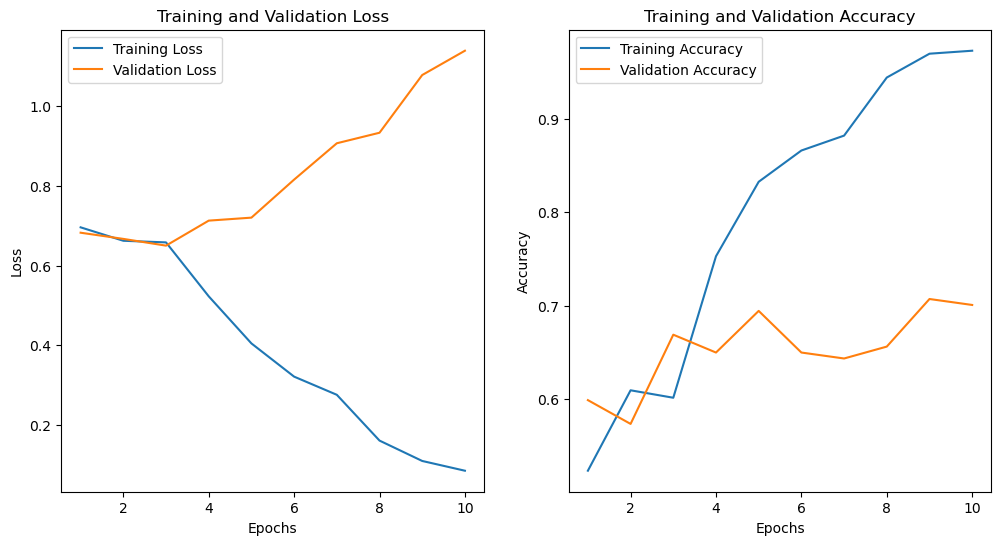

In [19]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df_mass_filtered, test_size=0.2, random_state=42)

# Dataset class
class MammogramDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['corrected image file path']
        label = 1 if self.dataframe.iloc[idx]['pathology'].lower() == 'malignant' else 0
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = MammogramDataset(train_df, transform=transform)
val_dataset = MammogramDataset(val_df, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

import torch.nn as nn
import timm

# Load the pre-trained Swin-T model
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

# Modify the classifier to match the number of classes
class SwinTransformerWithPooling(nn.Module):
    def __init__(self, model):
        super(SwinTransformerWithPooling, self).__init__()
        self.swin = model
        self.pool = nn.AdaptiveAvgPool1d(1)  # Pooling layer for reducing the patch dimension
        self.fc = nn.Linear(model.num_features, 1)  # Final output layer with 1 output unit

    def forward(self, x):
        x = self.swin.forward_features(x)  # Extract features using Swin Transformer
        print(f"Shape after forward_features: {x.shape}")  # Expected: [batch_size, 7, 7, 768]
        
        x = x.mean(dim=[1, 2])  # Global Average Pooling over both the spatial dimensions (7x7 -> 1)
        print(f"Shape after global average pooling: {x.shape}")  # Expected: [batch_size, 768]
        
        x = self.fc(x)  # Pass through the linear layer
        print(f"Shape after linear layer: {x.shape}")  # Expected: [batch_size, 1]
        
        return x


# Wrap the Swin Transformer model with our custom classifier
model = SwinTransformerWithPooling(model)

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    # Lists to store the metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for i, (inputs, labels) in enumerate(train_loader):
            print(f"Processing batch {i+1}")
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1).float()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate the loss and correct predictions
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5  # Convert logits to binary predictions
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

            print(f"Batch {i+1}, Loss: {loss.item():.4f}")

        # Calculate average loss and accuracy for this epoch
        epoch_loss = running_loss / total_preds
        epoch_acc = correct_preds / total_preds
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_correct_preds = 0
        val_total_preds = 0
        val_running_loss = 0.0

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device).unsqueeze(1).float()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs) > 0.5  # Convert logits to binary predictions
                val_correct_preds += torch.sum(preds == labels).item()
                val_total_preds += labels.size(0)

        # Calculate average validation loss and accuracy
        val_epoch_loss = val_running_loss / val_total_preds
        val_epoch_acc = val_correct_preds / val_total_preds
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}')

        # Step the scheduler if used
        scheduler.step()

    # Plotting the training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return model

# Train the model with validation accuracy and plot the results
model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)